In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
import os
os.environ['LMTOPTIONS'] = '--skip-power=1'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import nengo
import nengo_dl
import nengo_loihi
from nengo_loihi.inputs import DVSFileChipNode  # branch: dvs-file-cores

from pytry.read import text
    
import davis_tracking
print(davis_tracking.__file__)

/home/arvoelke/.conda/envs/nx085/lib/python3.5/site-packages/nengo_dl/version.py:32: UserWarning: This version of `nengo_dl` has not been tested with your `nengo` version (3.0.0.dev0). The latest fully supported version is 2.8.0.
  ((nengo.version.version,) + latest_nengo_version))


/home/arvoelke/git/davis_tracking/davis_tracking/__init__.py


In [3]:
# model file generated via:
# repo: https://github.com/tcstewar/davis_tracking/
# branch: nengo_spiking
#     with ``np.abs(imgs) / p.merge**2 / p.decay_time`` on all the images returned from load_data
#     and max_rate set to 2000
# pytry track_deep_heat_spiking.py --n_epochs=200 --n_data=-1 --test_set=one --save_params=True --seed=0 --saturation=1000000000 --n_features_1=3 --n_parallel=3

#trained = os.path.abspath("data/TrackingTrial#20190618-162329-1d221ee6")
#trained = os.path.abspath("data/TrackingTrial#20190619-172004-8f255967")
#trained = os.path.abspath("data/TrackingTrial#20190620-120606-88b07493")
trained = os.path.abspath("data/TrackingTrial#20190620-161158-82afa6c5")
pdict = text("%s.txt" % trained)
p = namedtuple("Params", pdict.keys())(*pdict.values())
params = np.load("%s.params.npy" % trained, allow_pickle=True)

In [4]:
testfile = '../dataset/retinaTest96.events'

dt = 0.001
times, images, targets = davis_tracking.load_data(
    testfile,
    dt=dt,
    decay_time=p.decay_time,
    separate_channels=p.separate_channels,
    saturation=p.saturation,
    merge=p.merge)

images = np.abs(images) / p.merge**2 / p.decay_time  # to be consistent with DVSFileChipNode

times.shape, images.shape, targets.shape

((703,), (703, 72, 48), (703, 4))

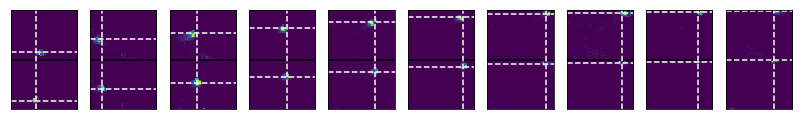

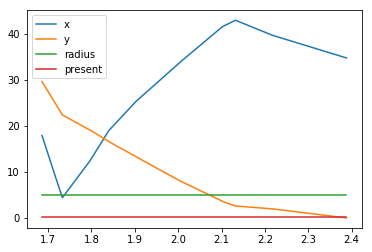

In [5]:
N = 10
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(images[index]) #, vmin=-1, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    plt.axhline(images.shape[1]//2, c='k')
    plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

plt.figure()
plt.plot(times, targets)
plt.legend(['x', 'y', 'radius', 'present'])

plt.show()

In [6]:
# copied over from track_deep_heat.py:
strip_edges = 3  #  the number of edge pixels to remove due to convolution
assert p.separate_channels
shape = (2, 180//p.merge, 240//p.merge)
output_shape = shape[1]-strip_edges*2, shape[2]-strip_edges*2
max_rate = 2000

In [7]:
# this is a hack to handle the fact that the CNN
# was trained with filtered events while
# spikes are implicitly scaled by 1/dt
scale_input_by_dt = True

t_start = times[0]

dimensions = shape[0]*shape[1]*shape[2]

with nengo.Network() as model:
    inp = DVSFileChipNode(filename=testfile, t_start=t_start, pool=(p.merge, p.merge),
                          channels_last=False)
    assert inp.dt == dt

    #inp = nengo.Node(output=nengo.processes.PresentInput(
    #    images.reshape(images.shape[0], -1), dt))
    
    #p_inp = nengo.Probe(inp, synapse=p.decay_time)
    
    # force `out` to run on the host so that the merged
    # output is stapled together on the host, and then
    # use_neurons for the final layer because nengo_loihi doesn't
    # currently support probing a convolutional tranform
    out = nengo.Node(lambda t, x: x, size_in=np.prod(output_shape))
    
    convnet = davis_tracking.ConvNet(nengo.Network(), max_rate=max_rate)
    
    convnet.input = inp
    
    convnet.make_input_layer(
            shape,
            spatial_stride=(p.spatial_stride, p.spatial_stride), 
            spatial_size=(p.spatial_size, p.spatial_size))
    
    #nengo.Connection(inp, convnet.input)
    
    init = params[2]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    if scale_input_by_dt:
        init = init * dt
    convnet.make_middle_layer(n_features=p.n_features_1, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init)
    init = params[3]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=p.n_features_2, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init)
    init = params[4]['transform'].init #if params is not None else nengo.dists.Uniform(-1, 1)
    convnet.make_middle_layer(n_features=1, n_parallel=p.n_parallel, n_local=1,
                              kernel_stride=(1,1), kernel_size=(3,3), init=init, use_neurons=True)
    convnet.make_merged_output(output_shape)
    nengo.Connection(convnet.output, out)
    
    # probes = []
    # for ensemble in model.all_ensembles:
    #     probes.append(
    #         nengo.Probe(ensemble.neurons, synapse=None))

    p_out = nengo.Probe(out, synapse=None)

    if params is not None:
        assert np.allclose(params[0]['gain'], max_rate, atol=1e-5)
        assert np.allclose(params[1]['gain'], max_rate, atol=1e-5)
        if np.max(np.abs(params[0]['bias'])) > 1e-8:
            print('WARNING: biases are not yet being set on the neurons')
        if np.max(np.abs(params[1]['bias'])) > 1e-8:
            print('WARNING: biases are not yet being set on the neurons')

In [8]:
convert_to_spiking = True
add_synapses = p.decay_time

print("=====================")

if convert_to_spiking:
    n_ensembles = 0
    for ens in model.all_ensembles:
        if isinstance(ens.neuron_type, nengo.RectifiedLinear):
            assert ens.neuron_type.amplitude == 1 / max_rate, ens.neuron_type.amplitude
            n_ensembles += 1
            ens.neuron_type = nengo.SpikingRectifiedLinear(
                amplitude=ens.neuron_type.amplitude)
    print("Changed %d ensembles" % n_ensembles)
    
if add_synapses is not None:    
    n_synapses = 0
    for conn in model.all_connections:
        if conn.synapse is None:
            n_synapses += 1
            conn.synapse = add_synapses
    print("Changed %d synapses" % n_synapses)

print("=====================")

Changed 105 ensembles
Changed 175 synapses


In [9]:
from nengo_loihi.hardware.allocators import GreedyChip

with nengo_loihi.Simulator(model, dt=dt, precompute=True, target="loihi",
                           hardware_options={'allocator': GreedyChip(2)}) as sim:
#with nengo.Simulator(model, dt=dt) as sim:
    sim.run_steps(len(times))

/home/arvoelke/git/nengo-loihi/nengo_loihi/simulator.py:170: UserWarning: No precomputable objects. Setting precompute=True has no effect.
  warnings.warn("No precomputable objects. Setting "


time 1: 16206 spikes
time 2: 101 spikes
time 3: 72 spikes
time 4: 69 spikes
time 5: 77 spikes
time 6: 88 spikes
time 7: 66 spikes
time 8: 88 spikes
time 9: 92 spikes
time 10: 66 spikes
time 11: 99 spikes
time 12: 85 spikes
time 13: 87 spikes
time 14: 104 spikes
time 15: 89 spikes
time 16: 83 spikes
time 17: 84 spikes
time 18: 70 spikes
time 19: 82 spikes
time 20: 85 spikes
time 21: 60 spikes
time 22: 69 spikes
time 23: 81 spikes
time 24: 75 spikes
time 25: 82 spikes
time 26: 68 spikes
time 27: 63 spikes
time 28: 74 spikes
time 29: 78 spikes
time 30: 670 spikes
time 31: 55 spikes
time 32: 47 spikes
time 33: 52 spikes
time 34: 46 spikes
time 35: 55 spikes
time 36: 50 spikes
time 37: 56 spikes
time 38: 52 spikes
time 39: 71 spikes
time 40: 63 spikes
time 41: 67 spikes
time 42: 145 spikes
time 43: 44 spikes
time 44: 87 spikes
time 45: 73 spikes
time 46: 85 spikes
time 47: 80 spikes
time 48: 90 spikes
time 49: 72 spikes
time 50: 82 spikes
time 51: 85 spikes
time 52: 90 spikes
time 53: 66 sp

time 679: 9 spikes
time 680: 8 spikes
time 681: 26 spikes
time 682: 7 spikes
time 683: 5 spikes
time 684: 5 spikes
time 685: 11 spikes
time 686: 10 spikes
time 687: 12 spikes
time 688: 8 spikes
time 689: 23 spikes
time 690: 27 spikes
time 691: 5 spikes
time 692: 3 spikes
time 693: 4 spikes
time 694: 10 spikes
time 695: 9 spikes
time 696: 13 spikes
time 697: 8 spikes
time 698: 9 spikes
time 699: 5 spikes
time 700: 9 spikes
time 701: 12 spikes
time 702: 9 spikes
time 703: 9 spikes
time 704: 7 spikes
time 705: 3 spikes
time 706: 15 spikes
time 707: 9 spikes
time 708: 10 spikes
time 709: 6 spikes
time 710: 9 spikes
time 711: 7 spikes
time 712: 7 spikes
time 713: 13 spikes
time 714: 7 spikes
time 715: 10 spikes
time 716: 14 spikes
time 717: 8 spikes
time 718: 10 spikes
time 719: 9 spikes
time 720: 16 spikes
time 721: 18 spikes
time 722: 11 spikes
time 723: 8 spikes
time 724: 8 spikes
time 725: 9 spikes
time 726: 3 spikes
time 727: 238 spikes
time 728: 65 spikes
time 729: 3 spikes
time 730: 

time 1422: 1 spikes
time 1423: 2 spikes
time 1424: 0 spikes
time 1425: 1 spikes
time 1426: 1 spikes
time 1427: 65 spikes
time 1428: 13 spikes
time 1429: 13 spikes
time 1430: 0 spikes
time 1431: 1 spikes
time 1432: 0 spikes
time 1433: 0 spikes
time 1434: 2 spikes
time 1435: 3 spikes
time 1436: 1 spikes
time 1437: 1 spikes
time 1438: 2 spikes
time 1439: 1 spikes
time 1440: 30 spikes
time 1441: 0 spikes
time 1442: 1 spikes
time 1443: 0 spikes
time 1444: 0 spikes
time 1445: 0 spikes
time 1446: 2 spikes
time 1447: 0 spikes
time 1448: 2 spikes
time 1449: 0 spikes
time 1450: 2 spikes
time 1451: 0 spikes
time 1452: 0 spikes
time 1453: 0 spikes
time 1454: 1 spikes
time 1455: 2 spikes
time 1456: 0 spikes
time 1457: 2 spikes
time 1458: 0 spikes
time 1459: 3 spikes
time 1460: 0 spikes
time 1461: 1 spikes
time 1462: 2 spikes
time 1463: 0 spikes
time 1464: 1 spikes
time 1465: 0 spikes
time 1466: 1 spikes
time 1467: 1 spikes
time 1468: 1 spikes
time 1469: 0 spikes
time 1470: 2 spikes
time 1471: 1 spi

/home/arvoelke/git/nxsdk/nxsdk-0.8.5/nxsdk/graph/nxinputgen/../../snips/
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.42.0.100:33257
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 28.17s
INFO:DRV:      Compiling snips.............Done 0.37s
INFO:DRV:      Encoding probes.............Done 4.58ms
INFO:DRV:      Booting up..................Done 2.60s
INFO:DRV:      Configuring registers.......Done 4.68s
INFO:DRV:      Transferring spikes.........Done 0.33s
INFO:DRV:      Transferring probes.........Done 0.03s
INFO:DRV:      Executing...................Done 3.73s
INFO:DRV:      Processing timeseries.......Done 0.31s
INFO:DRV:  Executor: 703 timesteps.........Done 40.47s


In [10]:
len(sim.model.split._chip_objects)

106

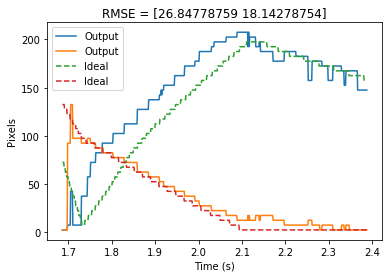

In [11]:
data = sim.data[p_out]  # [:len(targets_test)]

targets_heatmap = davis_tracking.make_heatmap(
    targets, merge=p.merge, strip_edges=strip_edges).reshape(len(targets), -1)

data_peak = np.array([davis_tracking.find_peak(img.reshape(output_shape)) for img in data])
target_peak = np.array([davis_tracking.find_peak(img.reshape(output_shape)) for img in targets_heatmap])

rmse_test = np.sqrt(np.mean((target_peak-data_peak)**2, axis=0))*p.merge          
if plt:
    plt.title("RMSE = %s" % (rmse_test,))
    plt.plot(times, data_peak*p.merge, label="Output")
    plt.plot(times, target_peak*p.merge, ls='--', label="Ideal")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Pixels")
    plt.show()
    #plt.plot((targets-strip_edges)*p.merge, ls=':')

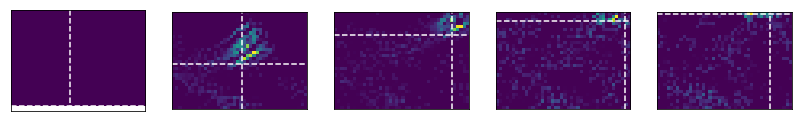

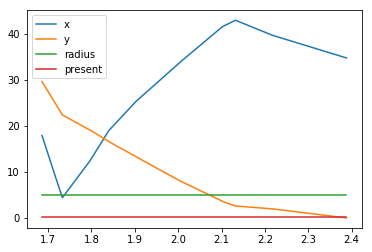

In [12]:
N = 5
plt.figure(figsize=(14,8))
indices = np.linspace(0, len(times)-1, N).astype(int)
for i, index in enumerate(indices):
    plt.subplot(1, N, i+1)
    plt.imshow(data[index].reshape(output_shape))
    #plt.imshow(images[index])
    #plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.axhline(targets[index,1], c='w', ls='--')
    #plt.axhline(images.shape[1]//2, c='k')
    #plt.axhline(targets[index,1]+images.shape[1]//2, c='w', ls='--')
    plt.axvline(targets[index,0], c='w', ls='--')

plt.figure()
plt.plot(times, targets)
plt.legend(['x', 'y', 'radius', 'present'])

plt.show()

NameError: name 'probes' is not defined

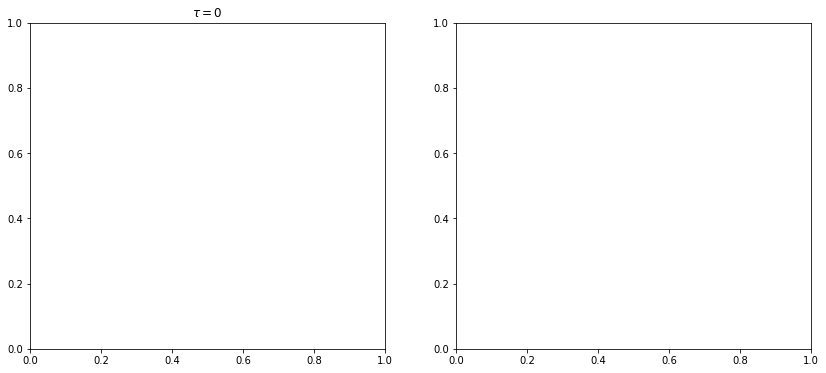

In [13]:
taus = [0, p.decay_time]
fig, ax = plt.subplots(1, len(taus), figsize=(14, 6))

R = []
colors = np.zeros((len(times), 4))

for i, tau in enumerate(taus):
    ax[i].set_title(r"$\tau = %s$" % tau)
    syn = nengo.Lowpass(tau)
    for j in range(len(probes)):
        a = sim.data[probes[j]] / ens.neuron_type.amplitude
        R.append(np.count_nonzero(a) / a.size / dt)
        #plt.show()
        y = syn.filt(np.mean(a, axis=1), dt=dt, y0=0)
        #colors[:, :3] = j / len(probes)
        #assert len(colors) == len(y)
        ax[i].plot(sim.trange(), y)#, c=colors.tolist())
plt.show()

plt.figure()
plt.hist(R)
plt.show()